In [27]:
import numpy as np
import pandas as pd
import os
import sys


import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.svm import SVR
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import pyro
from pyro.distributions import Binomial, Normal
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import bernoulli, binom
from sklearn import linear_model

from numpy import asarray
from numpy import savetxt

In [64]:
# Hyperparameter

REP = 20
# total_beta_sample = 100

num_epochs = 5000
EPSILON = 1
lambda_val = 0.02
BATCH_SIZE = 64

RES_DICT = {'REP': REP, 'BATCH_SIZE': BATCH_SIZE}

data_path = 'data/mehrab_GTEx_sample/'

simple_model = False


In [5]:
genes = os.listdir(data_path)

In [205]:
len(genes)

101

In [6]:
gene_name = genes[0]
print(gene_name)
matrix_path = data_path + gene_name + '/'


ENSG00000272821.1


In [7]:
expression_for_each_gene = pd.read_csv(matrix_path + 'expression.csv') # Y variable (though we have multiple Y's and we can select one of them!
expression_for_each_gene.shape

(54, 949)

In [79]:
np.sum(pd.isna(expression_for_each_gene).values, axis=-1)
less_nan_value_index = np.argsort(np.sum(pd.isna(expression_for_each_gene).values, axis=-1))[0]
target_variable = expression_for_each_gene.iloc[less_nan_value_index, :]
target_variable = target_variable.dropna()
print(target_variable.values[0])
y = target_variable.values[1:].astype(np.float64)
sample_names = list(target_variable.index[1:])

Muscle - Skeletal


In [80]:
input_matrix = pd.read_csv(matrix_path + 'genotype.012')
genotype_matrix = input_matrix.loc[input_matrix['Unnamed: 0'].isin(sample_names)].values
X = genotype_matrix[:, 1:].astype(np.float64)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [84]:
class Loader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genotype_matrix, expression, batch_size=1):

        self.expression = expression
        self.genotype_matrix = genotype_matrix

        self.batch_size = batch_size

    def __len__(self):
        return len(self.genotype_matrix)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        real_samples = self.genotype_matrix[idx, ]
        samples = real_samples
        labels = self.expression[idx, ]
        batch = {'x': samples.astype(np.float64), 'y': labels}

        return batch



def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [85]:
dataset = Loader(X_train, y_train)

In [169]:
gamma_dist = Gamma(1, 1 / 0.7, validate_args=True)

In [178]:
min(gamma_dist.sample_n(100000))

tensor(1.2232e-06)

In [185]:
from pyro.distributions import Normal, Gamma, MultivariateNormal
# from scipy.stats import gamma
alpha_gam = 1
beta_gam = 0.7


def prior_sample(size=1):
    gamma_dist = Gamma(alpha_gam, 1 / beta_gam)
    sigma = gamma_dist.sample(sample_shape=torch.Size([size]))

    normal_dist = Normal(0, sigma)
    beta = normal_dist.sample()
    return beta, sigma

def prior_prob(beta, sigma):
    gamma_dist = Gamma(alpha_gam, 1 / beta_gam, validate_args=True)
    sigma = torch.clip(sigma, 0 + 1e-9, torch.max(sigma))
    p_sig = torch.exp(gamma_dist.log_prob(sigma))
    normal_dist = Normal(0, sigma)
    p_beta = torch.exp(normal_dist.log_prob(beta))

    return p_beta, p_sig


In [186]:
def metropolis_heisting(cur_beta, cur_sigma, cur_prob_theta, geno_mat, h_classifier):

#     changed_value = np.full(cur_theta_prob.shape, 1)
    counter = 0

    while(True):
        new_beta = MultivariateNormal(cur_beta.float(), var.float()).sample()
        new_sigma = MultivariateNormal(cur_sigma.float(), var.float()).sample()

        # new_beta = torch.clip(new_beta, -2, 2)

        beta_prob, sigma_prob = prior_prob(new_beta, cur_sigma)
        new_ys = torch.matmul(geno_mat.float(), new_beta)
        with torch.no_grad():
            r_value = h_classifier(new_ys, geno_mat, new_beta, cur_sigma)
            r_value = torch.mean(r_value, dim=0)
            r_value = r_value / (1 - r_value)
            new_theta_prob = r_value * beta_prob * sigma_prob

            rho = ((new_theta_prob) / (cur_prob_theta + 1e-7)).cpu().detach().numpy()
            rho[rho > 1] = 1
    #         rho = rho * changed_value
    #        rho = min(1, (new_theta_prob)/(cur_theta_prob))
            random_num = np.random.rand()
            if np.isnan(np.sum(rho)):
                print("EROR ------------------------")
                print(np.isnan(np.sum(cur_prob_theta)))
                print(np.isnan(np.sum(new_prob_theta)))

            if random_num < np.mean(rho):
                cur_beta = new_beta
                cur_sigma = cur_sigma
                cur_theta_prob = new_theta_prob
                # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
                return cur_sigma, cur_beta, cur_theta_prob, new_ys

        counter += 1

        if counter > REP:
#             print("It Takes quite time :(")
            cur_beta = (new_beta + cur_beta) / 2
            cur_sigma = (new_sigma + cur_sigma) / 2
            cur_theta_prob = (new_theta_prob + cur_prob_theta) / 2
            # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
            return torch.clip(cur_sigma, 1e-9, torch.max(cur_sigma)), cur_beta, cur_theta_prob, new_ys

In [187]:

class Classifier(nn.Module):

    def __init__(self, input_dim, num_classes=1):
        super(Classifier, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        # self.layer_1 = nn.Linear(input_dim, 1)
        # self.act1 = nn.ReLU()
        self.layer_out = nn.Linear(2, 1)
        self.out = nn.LogSoftmax(dim=1)


        self.criterion = nn.BCEWithLogitsLoss()

    def cross_entropy(self, x, y):
        n_d, h_d = x.shape

        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]

        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))

    def forward(self, y, genotypes_batch, beta, label=None, testing=False):

        y = torch.tensor(y).to(device).float()
        beta = torch.Tensor(beta).to(device)[:, None].float()
        genotypes_batch = torch.tensor(genotypes_batch).to(device).float()

        comparison_vector = torch.matmul(genotypes_batch, beta)

        # beta_summaries = self.act1(self.layer_1(beta))

        # x = torch.cat([y[:, None], torch.repeat_interleave(beta_summaries[None, :], y.shape[0], dim=0)], dim=1)
        x = torch.cat([y[:, None], comparison_vector], dim=-1)

        x = self.layer_out(x)

        logits = self.out(x)

        if label is not None:
            probs = torch.exp(logits) + 1e-6
            if testing:
              labels = probs.clone().squeeze()
              labels[labels >= 0.5] = 1
              labels[labels < 0.5] = 0
              print(torch.sum(torch.abs(labels - label)), "Wrong Preds out of", len(label))

              return [], []

            loss = self.criterion(probs, label[:, None])
            return probs, loss

        return torch.exp(logits[:,-1]) + 1e-6

    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

In [201]:
# threshold = 0.84
threshold = 21
# cor_thresh = 0.6
d = X_train.shape[1]
print_freq = 10

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running\ on the CPU")

print(EPSILON)

class LogisticRegression(nn.Module):

    def __init__(self, input_dim, num_classes=1):
        super(LogisticRegression, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.

        self.discriminator = nn.Sequential(nn.Conv1d(1, 4, kernel_size=5, stride=3),
                                           nn.LeakyReLU(0.2, inplace=0.2),
                                           nn.Dropout(0.5),
                                           nn.Conv1d(4, 8, kernel_size=4, stride=2),
                                           nn.LeakyReLU(0.2, inplace=True),
                                           nn.Dropout(0.3),
                                           nn.Conv1d(8, 4, kernel_size=4, stride=2),
                                           nn.LeakyReLU(0.2, inplace=True),
                                           nn.Dropout(0.1),
                                           nn.Conv1d(4, 1, kernel_size=4, dilation=1),
                                           nn.LeakyReLU(0.2, inplace=True))

        self.layer_out = nn.Sequential(nn.Linear(6, 1),
                                       nn.Sigmoid())

        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.1)
        # self.batchnorm1 = nn.BatchNorm1d(64)
        # self.batchnorm2 = nn.BatchNorm1d(64)

        self.criterion = torch.nn.BCELoss(size_average=False)


    def cross_entropy(self, x, y):
        n_d, h_d = x.shape

        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]

        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))

    def forward(self, y, genotypes_batch, beta, sigma, label=None, testing=False):

        y = torch.tensor(y).to(device).float()
        beta = torch.tensor(beta).to(device).float()
        sigma = torch.tensor(sigma).to(device).float()

        gamma_dist = Gamma(alpha_gam, 1 / beta_gam)
        sigma_n = gamma_dist.sample(sample_shape=sigma.shape)

        normal_dist = Normal(0, sigma_n)
        beta_f = normal_dist.sample()
        genotypes_batch = torch.tensor(genotypes_batch).to(device).float()

        pheno_fake_f = torch.matmul(genotypes_batch, beta)[:, None]
        pheno_fake_s = torch.matmul(genotypes_batch, beta_f)[:, None]
        y = y[:, None]


        # y = torch.Tensor(y).to(device)
        # beta = torch.Tensor(beta).to(device)

        # y = torch.repeat_interleave(y[:, None], d, dim=-1)
        # beta = torch.repeat_interleave(beta[None, :], y.shape[0], dim=0)

        x = torch.cat([beta, sigma], dim=-1)[None, None, :]

#         out = self.linear(x)
#         out = self.activation(out)
        x = self.discriminator(x).squeeze()

        x = torch.repeat_interleave(x[None, :], y.shape[0], dim=0)
        lab_vec = torch.cat([y, pheno_fake_f, pheno_fake_s], dim=-1)
        aux_loss = nn.MSELoss()(x, lab_vec)
        x = torch.cat([x, lab_vec], dim=-1)

        # x = self.batchnorm1(x)

        # x = self.batchnorm2(x)
        # x = self.dropout(x)
        # x = torch.squeeze(self.layer_out(x))

        probs = self.layer_out(x)

        # print(x[x>0].shape, "CLASSIFIER")
        # input()

        if label is not None:

            loss = self.criterion(probs, label[:, None])

            if testing:
              predicted = torch.round(probs).squeeze()
              print(float((len(label) - torch.sum(torch.abs(predicted - label)))) / len(label) * 100.0, " % acc")

              return torch.sum(torch.abs(predicted - label))

            return probs, loss + aux_loss

        return probs

    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

Running\ on the CPU
1


In [202]:

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

if simple_model:
  classifier = Classifier(d).to(device)
else:
  classifier = LogisticRegression(d * 2).to(device)

print(classifier.get_n_params())

optimizer = optim.Adam(classifier
                         .parameters(), lr=0.0002)

losses = []
distances = []

denum = X_train.shape[0] / BATCH_SIZE

losses = []


# Sampling beta
proper_beta_samples = []
proper_sigma_samples = []
# proper_beta_samples_distances = []

all_beta = []

counter = 0

# RES_DICT['total_beta_sample'] = total_beta_sample


distance = -1


##### Saving
min_dist = 0
best_model = None

var = torch.tensor(np.eye(d) * (0.5 / 50), dtype=torch.float64)

316


  0%|          | 0/5000 [00:00<?, ?it/s]

---------
Validation distance: 30.868854566464385
Validation correlation: -0.007488927448427661
EPOCH 0
Total Error tensor(169298.6250, grad_fn=<DivBackward0>)
54 LEN


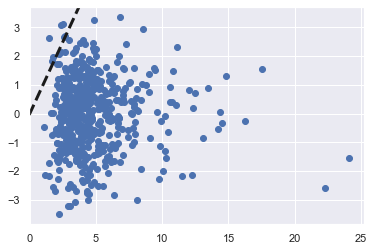

 10%|█         | 500/5000 [01:00<05:54, 12.68it/s]  

96.6542750929368  % acc
93.86617100371747  % acc
95.2602207660675 %
Best modedl changed
---------
Validation distance: 31.198209345232467
Validation correlation: -0.028012753453596665
EPOCH 500
Total Error tensor(163157.9844, grad_fn=<DivBackward0>)
364 LEN


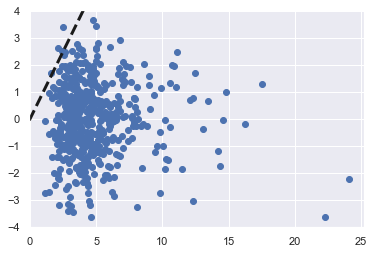

 20%|█▉        | 996/5000 [02:04<08:18,  8.03it/s]


EROR ------------------------


TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)


In [204]:
for epoch in tqdm(range(num_epochs)):

    error_sum = 0
    distance_sum = 0

#     var = np.eye(d) * (0.75 / (epoch + 1))

    cur_beta, cur_sigma = prior_sample(d)

    cur_ys = np.dot(X_train, cur_beta)
    cur_ys -= np.mean(cur_ys)
    cur_ys /= np.var(cur_ys)
    beta_prob, sigma_prob = prior_prob(torch.tensor(cur_beta), torch.tensor(cur_sigma))
    # cur_r_value = classifier(cur_ys, train_genotypes.astype(np.float64), cur_beta).cpu().detach().numpy()
    # cur_r_value = np.mean(cur_r_value, axis=0)
    cur_r_value = classifier(cur_ys, X_train.astype(np.float16), cur_beta, cur_sigma)

    cur_r_value = torch.mean(cur_r_value, dim=0)
    cur_r_value = cur_r_value / (1 - cur_r_value)

    cur_theta_prob = cur_r_value * beta_prob * sigma_prob

    for n_batch, batch in enumerate(data_loader):

        optimizer.zero_grad()

        N = batch['x'].size(0)

        geno_batch = batch['x']
        pheno_batch = batch['y']

        sampled_sigma, sampled_beta, prob_theta, sampled_y, = metropolis_heisting(cur_beta, cur_sigma, cur_theta_prob, geno_batch, classifier)
#         sampled_y = torch.sigmoid(torch.tensor(sampled_y)).numpy()

#         sampled_y = sampled_y
        sampled_y -= sampled_y.mean()
        sampled_y /= sampled_y.std()

        # sampled_y *= -1

        distance = torch.mean((sampled_y - pheno_batch) ** 2)
        correlation = pearsonr(pheno_batch, sampled_y)[0]


#         print(distance)
        distance_sum += distance

        _, loss_f = classifier(sampled_y, geno_batch, sampled_beta, sampled_sigma, label=torch.full(sampled_y.shape, 0.0))
        _, loss_r = classifier(pheno_batch, geno_batch, sampled_beta, sampled_sigma, label=torch.full(pheno_batch.shape, 1.0))

#         _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
#         loss_f *= ((distance ** 2))

#         _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
#         loss_r *= ((distance ** 2))

        loss = loss_f + loss_r
        loss *= (distance ** 2)

        # loss += lambda_val * torch.mean(torch.abs(sampled_beta))
        # / d + torch.mean((sampled_beta - betas) ** 2))

        loss.backward()

        optimizer.step()
        error_sum += loss

        # proper_beta_samples.append(sampled_beta.cpu().detach().numpy())
        if distance < 1:
          all_beta.append(sampled_beta.cpu().detach().numpy())

        if distance < threshold:
          proper_beta_samples.append(sampled_beta.cpu().detach().numpy())
          proper_sigma_samples.append(sampled_sigma.cpu().detach().numpy())

        # proper_beta_samples_dist[distance] = sampled_beta.cpu().detach().numpy()

        cur_beta = sampled_beta.clone()
        cur_sigma = sampled_sigma.clone()
        cur_theta_prob = prob_theta

    proper_beta_samples_val = np.array(proper_beta_samples)
    proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)

    proper_sigma_samples_val = np.array(proper_sigma_samples)
    proper_sigma_samples_val = np.mean(proper_sigma_samples_val, axis=0)

    if len(proper_beta_samples) > 0:
            # print("Using proper sets")
            proper_beta_samples_val = np.array(proper_beta_samples)
            proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)

            proper_sigma_samples_val = np.array(proper_sigma_samples)
            proper_sigma_samples_val = np.mean(proper_sigma_samples_val, axis=0)

            val_y = np.dot(X_train, proper_beta_samples_val)

    else:
            val_y = np.dot(X_train, sampled_beta)

    val_y -= np.mean(val_y)
    val_y /= np.var(val_y)

    val_distance = np.mean((val_y - y_train) ** 2)
    val_correlation = pearsonr(y_train, val_y)[0]

    if (epoch % int(num_epochs / print_freq) == 0 and epoch >= int(num_epochs / print_freq)) or epoch == 0:
        if epoch > 0:
          wrongs_f = classifier(val_y, X_train, proper_beta_samples_val, proper_sigma_samples_val, label=torch.full(val_y.shape, 0.0), testing=True)
          wrongs_r = classifier(y_train, X_train, proper_beta_samples_val, proper_sigma_samples_val, label=torch.full(y_train.shape, 1.0), testing=True)
          acc = float(((len(val_y) + len(y_train) - (wrongs_f + wrongs_r)) / (len(val_y) + len(y_train))).detach().numpy())
          print(acc * 100, '%')
          if min_dist < acc:
            min_dist = acc
            best_model = torch.save(classifier.state_dict(), "./best_modedl.pt")
            print("Best modedl changed")


          # threshold = val_distance
          # cor_thresh = val_correlation

          # print(threshold)
          # print(cor_thresh, "CORR")

        print("---------")
        print("Validation distance:", val_distance)
        print("Validation correlation:", val_correlation)
        print("EPOCH", epoch)
        print("Total Error", error_sum / n_batch) ####
        print(len(proper_beta_samples), 'LEN')


        plt.scatter(y_train, val_y)
        xpoints = ypoints = plt.xlim()
        plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
        plt.show()
#     print(distance_sum / denum)

    losses.append([error_sum / denum])
    distances.append([distance_sum / denum])

In [ ]:
X_train.shape

In [198]:
proper_beta_samples_val

nan